# Verification experiments
_Author: Bart van Erp_ 

_Date:   26-04-2022_

This notebook contains the verification experiments to the paper **Modular Model-Based Online Source Separation using Non-Linear Autoregressive Models**.

## Load packages

In [1]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
function chirp(t, f_min, f_max, T, ϕ0)

    t = collect(t)

    # slope of frequency
    c = (f_max-f_min)/T

    # trajectory of frequency
    f = (2*abs.(t/T - floor.(t/T .+ 1/2)) ) .* (f_max - f_min) .+ f_min

    ϕ = cumsum(f).*(t[2] - t[1])

    return sin.(ϕ0 .+ 2*pi*ϕ)

end

chirp (generic function with 1 method)

In [3]:
# generate data if it does not exist yet
t = 0:0.01:10
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/signal")
    mkdir("data/noise")
    mkdir("data/mix")
    mkdir("data/mix_signal")
    mkdir("data/mix_noise")

    # generate data and save
    start_signal = 10*randn(2000)
    start_noise  = 10*randn(1000)
    start_mix    = 10*randn(3000)
    amps         = 5*rand(3000)
    f0 = 5
    f1 = 20
    T = 3
    for k = 1:1000
        ts = collect(t) .+ start_signal[k]
        h5write(string("data/signal/", k, ".h5"), "signal", amps[k] * chirp(t, f0, f1, T, start_signal[k+1000]))
        tn = collect(t) .+ start_noise[k]
        h5write(string("data/noise/",  k, ".h5"), "signal", amps[k] * sign.(cos.(2*π*10*tn)))
        tsm = collect(t) .+ start_mix[k]
        tnm = collect(t) .+ start_mix[k+2000]
        h5write(string("data/mix/",    k, ".h5"), "signal", amps[k+1000] * chirp(tsm, f0, f1, T, start_mix[k+1000]) + amps[k+2000] * sign.(cos.(2*π*10*tnm)))
        h5write(string("data/mix_signal/", k, ".h5"), "signal", amps[k+1000] * chirp(tsm, f0, f1, T, start_mix[k+1000]))
        h5write(string("data/mix_noise/",  k, ".h5"), "signal", amps[k+2000] * sign.(cos.(2*π*10*tnm)))
    end

end

In [4]:
# load data
data_signal = Data("data/signal/" .* readdir("data/signal"), Float64)
data_noise  = Data("data/noise/"  .* readdir("data/noise"),  Float64)
data_mix    = Data("data/mix/"    .* readdir("data/mix"),    Float64)
data_mix_signal = Data("data/mix_signal/"    .* readdir("data/mix_signal"), Float64)
data_mix_noise  = Data("data/mix_noise/"    .* readdir("data/mix_noise"),  Float64);

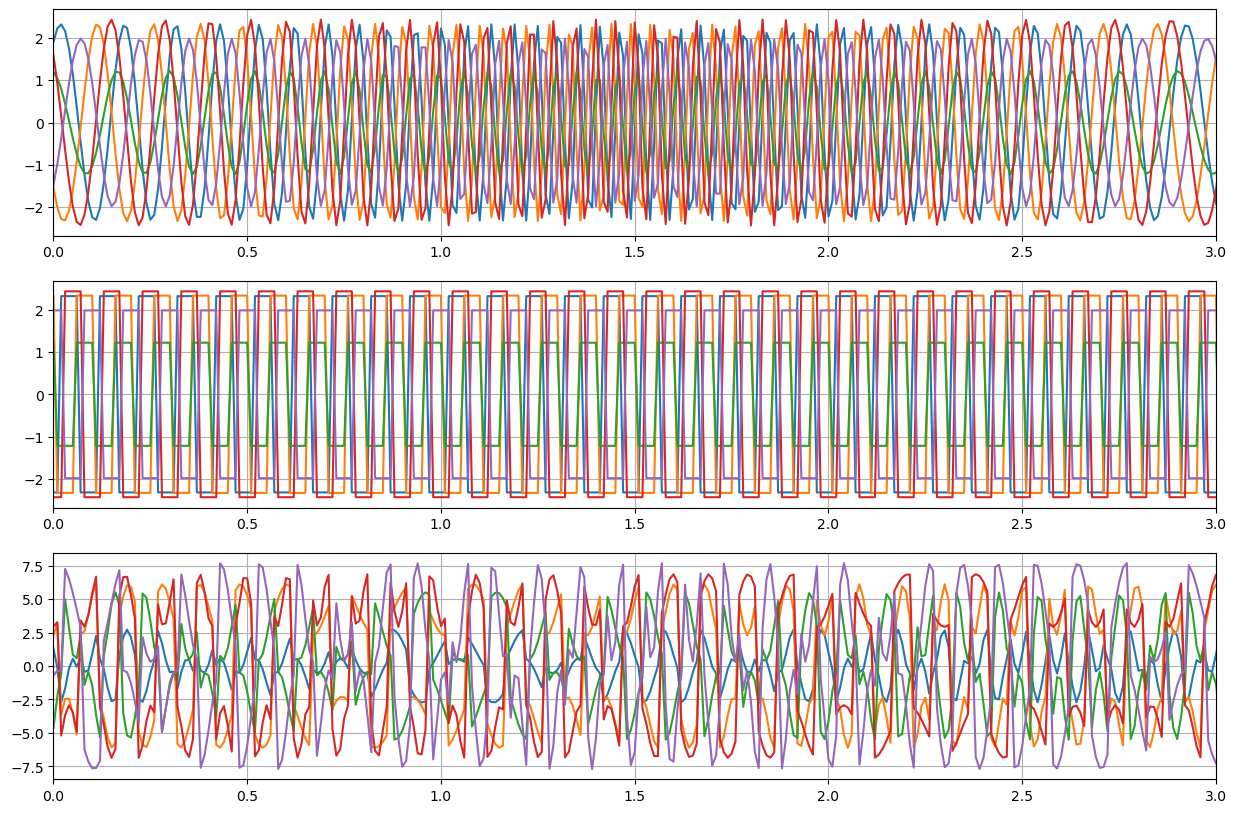

In [5]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(t, data_signal[k])
    ax[2].plot(t, data_noise[k])
    ax[3].plot(t, data_mix[k])
end
ax[1].set_xlim(0,3), ax[1].grid()
ax[2].set_xlim(0,3), ax[2].grid()
ax[3].set_xlim(0,3), ax[3].grid();

## Train models

In [6]:
function create_NAR_model(dim; shift=1, batch_size::Int=128)

    return SourceSeparationINN.Model(
        dim,
        (
            ARLayer(
                dim,
                SourceSeparationINN.Model(  
                    dim-shift,
                    shift,
                    (   
                        DenseSNLayer(dim-shift, 16, 1.0; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseSNLayer(16, 16, 1.0; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseSNLayer(16, shift, 1.0; batch_size=batch_size, optimizer=Adam),
                    );
                    batch_size=batch_size
                );
                batch_size=batch_size
            ),
        );
        batch_size=batch_size
    )
        
end
batch_size = 16
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [7]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_NAR_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_signal,            # train data
        data_signal,            # test data
        5,                      # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

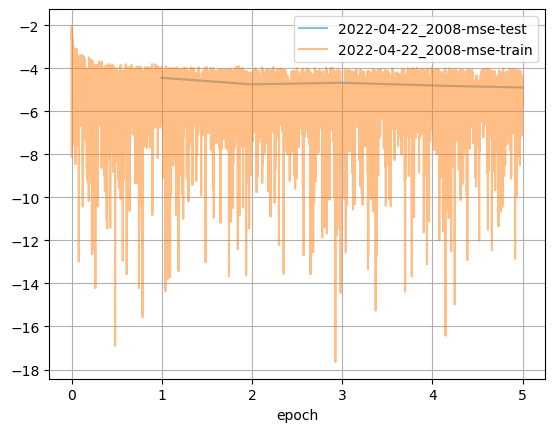

In [8]:
# plot loss function over training duration
plot_logs(; path="logs/signal/", logscale=true);

In [9]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_NAR_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_noise, 1e-5)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_noise,            # train data
        data_noise,            # test data
        5,                     # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

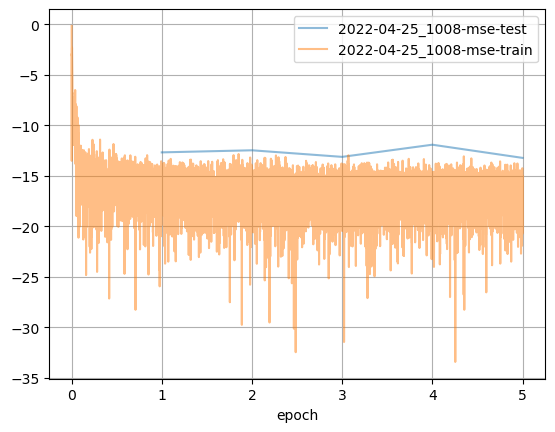

In [10]:
# plot loss function over training duration
plot_logs(; path="logs/noise/", logscale=true);

# Model specification

In [11]:
using ReactiveMP, GraphPPL, Rocket
include("../../reactivemp_extension.jl")

In [12]:
@model function observation_model(gs, gn, Hs, Hn, Qs, Qn, R)

    # specify data variables
    μ_s = datavar(Vector{Float64})
    μ_n = datavar(Vector{Float64})
    Σ_s = datavar(Matrix{Float64})
    Σ_n = datavar(Matrix{Float64})

    # specify priors
    s_prev ~ MvNormalMeanCovariance(μ_s, Σ_s)
    n_prev ~ MvNormalMeanCovariance(μ_n, Σ_n)

    # propagate priors through non-linearities
    s_trans ~ Nar(s_prev) where { meta = NarMeta(gs, Unscented(gs.dim_in)) }
    n_trans ~ Nar(n_prev) where { meta = NarMeta(gn, Unscented(gn.dim_in)) }

    # add process noise
    s ~ MvNormalMeanCovariance(s_trans, Qs)
    n ~ MvNormalMeanCovariance(n_trans, Qn)

    # form observation
    y = datavar(Float64)
    y ~ NormalMeanVariance(dot(Hs, s) + dot(Hn, n), R)

    # return variables
    return μ_s, μ_n, Σ_s, Σ_n, y, s, n

end

observation_model (generic function with 1 method)

## Specify priors

In [13]:
# specify observation model
Hs = zeros(dim_in)
Hs[1] = 1
Hn = zeros(dim_in)
Hn[1] = 1

# specify process noise 
Qs = zeros(dim_in, dim_in)
Qs[1,1] = exp(-5) * dim_in
Qn = zeros(dim_in, dim_in)
Qn[1,1] = exp(-13) * dim_in

# specify observation noise
R = 1e-10

# select signal
signal_mix = data_mix[1]

# set priors for underlying signals
m_s_prior = randn(dim_in)
V_s_prior = 1e2*diagm(ones(dim_in));
m_n_prior = randn(dim_in)
V_n_prior = 1e2*diagm(ones(dim_in));

# Perform inference

In [14]:
using ProgressMeter

In [15]:
function inference_Nar(data_y, Hs, Hn, Qs, Qn, R, ms, Vs, mn, Vn, gs, gn; progress=true)

    # fetch number of samples
    nr_samples = length(data_y)

    # create model
    model, (μ_s, μ_n, Σ_s, Σ_n, y, s, n) = observation_model(gs, gn, Hs, Hn, Qs, Qn, R)

    # allocate output
    separated_s = Vector{NormalMeanVariance}(undef, nr_samples)
    separated_n = Vector{NormalMeanVariance}(undef, nr_samples)

    # initialize buffers
    marg_s = keep(Marginal)
    marg_n = keep(Marginal)

    # subscribe to marginals
    s_sub = subscribe!(getmarginal(s), marg_s)
    n_sub = subscribe!(getmarginal(n), marg_n)
    
    # set priors
    μ_s_prior = copy(ms)
    Σ_s_prior = copy(Vs)
    μ_n_prior = copy(mn)
    Σ_n_prior = copy(Vn)

    # create optional progress bar
    p = Progress(nr_samples; enabled=progress)

    # loop through data
    for k in 1:nr_samples

        # update priors
        ReactiveMP.update!(μ_s, μ_s_prior)
        ReactiveMP.update!(Σ_s, Σ_s_prior)
        ReactiveMP.update!(μ_n, μ_n_prior)
        ReactiveMP.update!(Σ_n, Σ_n_prior)

        # update observation
        ReactiveMP.update!(y, data_y[k])

        # extract marginals
        μ_s_prior, Σ_s_prior = mean_cov(getvalues(marg_s)[end])
        μ_n_prior, Σ_n_prior = mean_cov(getvalues(marg_n)[end])

        # save marginals
        separated_s[k] = NormalMeanVariance(μ_s_prior[1], Σ_s_prior[1,1])
        separated_n[k] = NormalMeanVariance(μ_n_prior[1], Σ_n_prior[1,1])

        # update progress meter
        if progress
            ProgressMeter.next!(p)
        end

    end

    # unsubscribe
    unsubscribe!([s_sub, n_sub])

    # return values
    return separated_s, separated_n

end

inference_Nar (generic function with 1 method)

In [16]:
deployed_model_signal = deploy(model_signal)
deployed_model_noise = deploy(model_noise);

# Plot first results

In [17]:
separated_s, separated_n = inference_Nar(signal_mix, Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


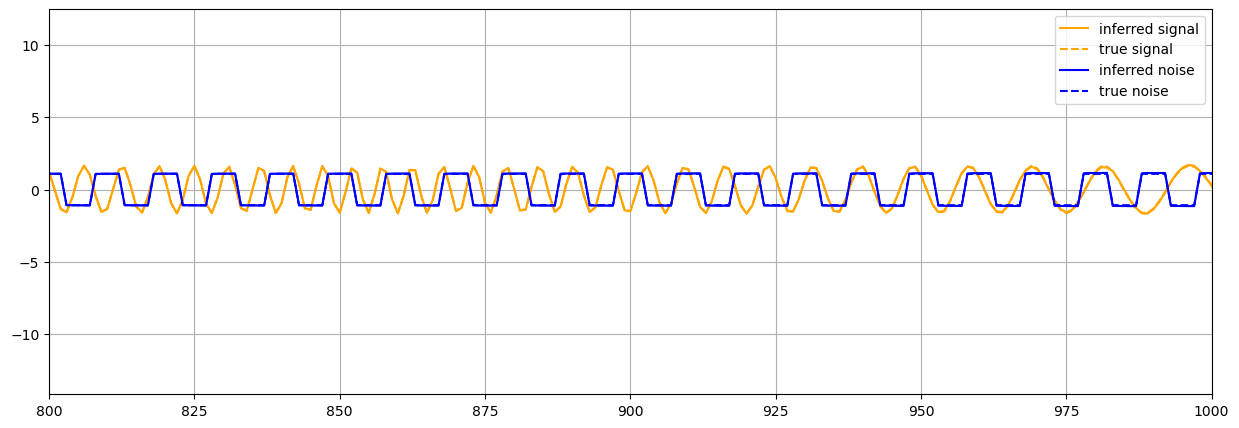

(800.0, 1000.0)

In [18]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(separated_s), mean.(separated_s) .- std.(separated_s), mean.(separated_s) .+ std.(separated_s) , color="orange", alpha=0.5)
plt.plot(1:length(separated_s), mean.(separated_s), color="orange", label="inferred signal")
plt.plot(1:length(separated_s), data_mix_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(separated_n), mean.(separated_n) .- std.(separated_n), mean.(separated_n) .+ std.(separated_n), color="blue", alpha=0.5)
plt.plot(1:length(separated_n), mean.(separated_n), color="blue", label="inferred noise")
plt.plot(1:length(separated_n), data_mix_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
# plt.ylim(-5,5)
plt.xlim(800,1000)

## Compute performance metrics

In [19]:
if !isfile("exports/metrics.h5")
    
    MSE_filtering  = Vector{Float64}(undef, length(data_mix))
    MAE_filtering  = Vector{Float64}(undef, length(data_mix))
    logp_filtering = Vector{Float64}(undef, length(data_mix))
    SNR_filtering  = Vector{Float64}(undef, length(data_mix))

    @showprogress for (ind, signal_mix) in enumerate(data_mix)

        # run source separation inference
        separated_s, separated_n = inference_Nar(signal_mix, Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise; progress=false);

        # calculate metrics
        MSE_filtering[ind]  = mean(abs2.(mean.(separated_s) - data_mix_signal[ind]))
        MAE_filtering[ind]  = mean(abs.(mean.(separated_s) - data_mix_signal[ind]))
        logp_filtering[ind] = mean([logpdf(Normal(mean(separated_s[k]), std(separated_s[k])), data_mix_signal[ind][k]) for k=1:length(separated_s)])
        SNR_filtering[ind]  = 10*log10(mean(abs2.(data_mix_signal[ind])) / mean(abs2.(mean.(separated_s) - data_mix_signal[ind])))
        
    end

    # save metrics
    h5write("exports/metrics.h5", "MSE",  MSE_filtering)
    h5write("exports/metrics.h5", "MAE",  MAE_filtering)
    h5write("exports/metrics.h5", "logp", logp_filtering)
    h5write("exports/metrics.h5", "SNR",  SNR_filtering)

else

    # load metrics
    MSE_filtering = h5read("exports/metrics.h5", "MSE")
    MAE_filtering = h5read("exports/metrics.h5", "MAE")
    logp_filtering = h5read("exports/metrics.h5", "logp")
    SNR_filtering = h5read("exports/metrics.h5", "SNR")

end;

Progress: 100%|█████████████████████████████████████████| Time: 0:10:44


In [20]:
mean(MSE_filtering), mean(MAE_filtering), mean(logp_filtering), mean(SNR_filtering)

(1.1804069701731135, 0.24371979093295434, -76.5839372965745, 10.107244097705875)

## Median MSE situation

In [21]:
# fetch index of median MSE
ind = argmin(abs.(MSE_filtering .- median(MSE_filtering)))

436

In [22]:
separated_s, separated_n = inference_Nar(data_mix[ind], Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [23]:
save("exports/separated_signals.jld2", "signal", separated_s)
save("exports/separated_signals.jld2", "noise", separated_n)

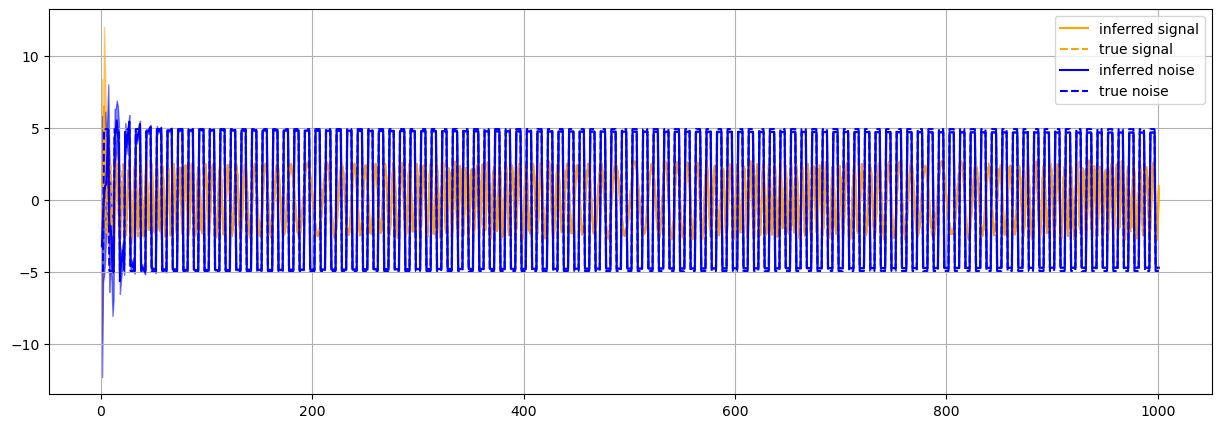

PyObject <matplotlib.legend.Legend object at 0x000000009FFE1AF0>

In [24]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(separated_s), mean.(separated_s) .- std.(separated_s), mean.(separated_s) .+ std.(separated_s) , color="orange", alpha=0.5)
plt.plot(1:length(separated_s), mean.(separated_s), color="orange", label="inferred signal")
plt.plot(1:length(separated_s), data_mix_signal[ind], color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(separated_n), mean.(separated_n) .- std.(separated_n), mean.(separated_n) .+ std.(separated_n), color="blue", alpha=0.5)
plt.plot(1:length(separated_n), mean.(separated_n), color="blue", label="inferred noise")
plt.plot(1:length(separated_n), data_mix_noise[ind], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
# plt.ylim(-5,5)
# plt.xlim(800,1000)

In [25]:
using PGFPlotsX

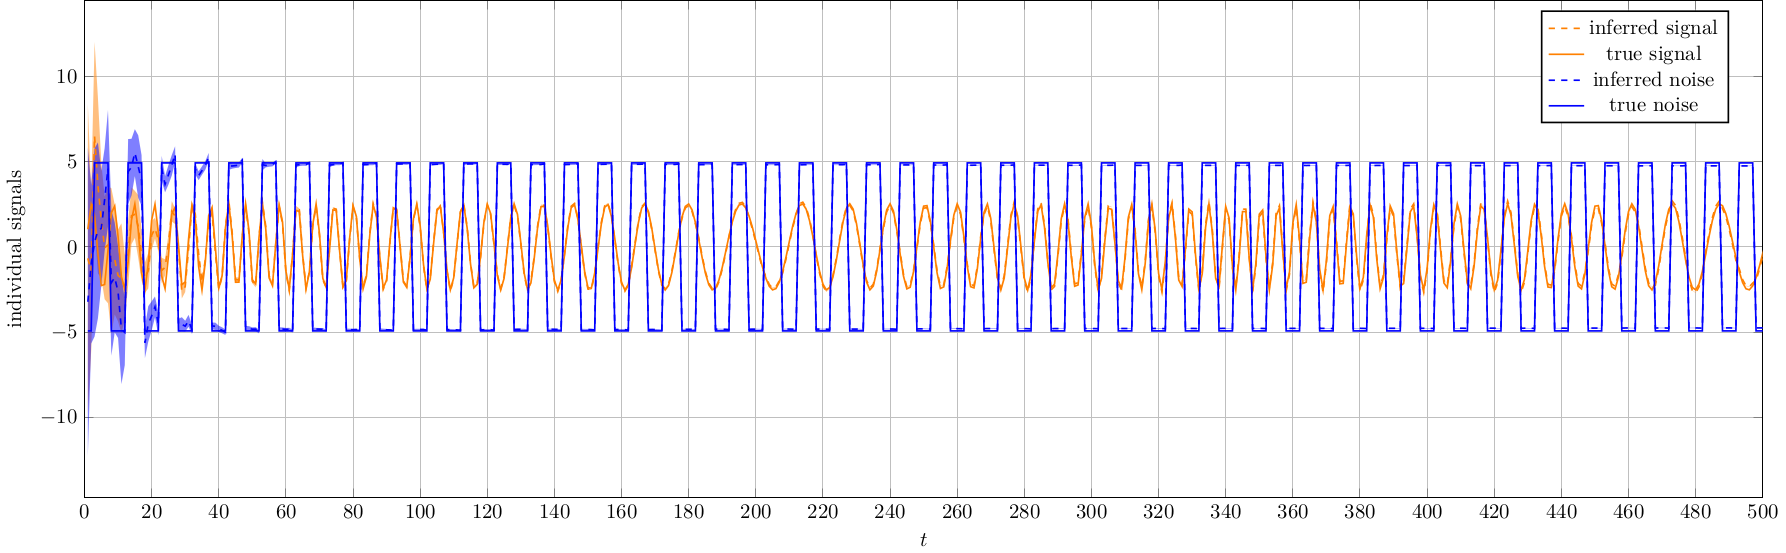

In [26]:
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}")

fig = @pgf Axis(
    
    # options
    {
        xlabel="\$t\$",
        ylabel="individual signals",
        grid = "major",
        style = {thick},
        width = "30cm",#"\\linewidth",
        height = "10cm",
        xmin = 0,
        xmax = 500
    },

    # fill signal
    Plot({ 
            "name path=signal1",
            draw="none",
            forget_plot,
        },
        Table(1:length(separated_s), mean.(separated_s).+std.(separated_s))
    ),
    Plot({ 
            "name path=signal2", 
            draw="none",
            forget_plot,
        }, 
        Table(1:length(separated_s), mean.(separated_s).-std.(separated_s))
    ), 
    Plot({ 
            color = "orange",
            fill = "orange",
            opacity = 0.5,
            forget_plot,
        }, 
        raw"fill between [of=signal1 and signal2]"
    ),

    # inferred signal
    Plot({
            thick,
            color="orange",
            dashed
        },
        Table(1:length(separated_s), mean.(separated_s))
    ),
    LegendEntry("inferred signal"),

    # true signal
    Plot({
            thick,
            color="orange"
        },
        Table(1:length(data_mix_signal[ind]), data_mix_signal[ind])
    ),
    LegendEntry("true signal"),

    # fill noise
    Plot({ 
            "name path=noise1",
            draw="none",
            forget_plot,
        },
        Table(1:length(separated_n), mean.(separated_n).+std.(separated_n))
    ),
    Plot({ 
            "name path=noise2", 
            draw="none", 
            forget_plot,
        }, 
        Table(1:length(separated_n), mean.(separated_n).-std.(separated_n))
    ), 
    Plot({ 
            color = "blue",
            fill = "blue",
            opacity = 0.5,
            forget_plot
        }, 
        raw"fill between [of=noise1 and noise2]"
    ),

    # inferred noise
    Plot({
        thick,
        color="blue",
        dashed,
        },
        Table(1:length(separated_n), mean.(separated_n))
    ),
    LegendEntry("inferred noise"),

    # true noise
    Plot({
        thick,
        color="blue"
        },
        Table(1:length(data_mix_noise[ind]), data_mix_noise[ind])
    ),
    LegendEntry("true noise"),
)

In [27]:
pgfsave("exports/chirp-block-unscented.tikz", fig)